[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/049_cv_ssd/cv_ssd.ipynb)

# **Detector SSD**

---


SSD (Single Shot Multibox Detector) es un modelo de detección de objetos que utiliza una sola red neuronal convolucional para predecir la presencia de objetos en una imagen. SSD es capaz de detectar objetos de diferentes tamaños y escalas gracias a la utilización varias capas de salida con distintos tamaños.

El modelo SSD es un modelo de una sola capa lo que se significa que nosotros somo resposables de darlo al modelo una conjunto de cajas que sea muy variado y durante el entrenamiento el algoritmo utilizará estas cajas para ver cuáles de las detecciones reales que tenemos en nuestro data set coinciden mejor con estas cajas y entonces optimizar sólo para aquellas que coinciden mejor este proceso de optimización pues básicamente consiste en acabar de adaptar la caja

# **Caracteristicas:**

principales características de los modelos SSD son:

* Uso de capas convolucionales: las redes convolucionales SSD utilizan capas convolucionales para extraer características de las imágenes de entrada. Estas características se utilizan posteriormente para realizar la detección de objetos.

* Predicción de múltiples escalas: las redes convolucionales SSD utilizan múltiples mapas de características de diferentes resoluciones. Esto permite que la red predictiva detecte objetos de diferentes tamaños y escalas.

* Utiliza la función de activación ReLU: ReLU (Rectified Linear Unit) es una función de activación que se utiliza con frecuencia en las redes neuronales para mejorar la velocidad y precisión del entrenamiento. Las redes convolucionales SSD también utilizan ReLU para reducir el tiempo de entrenamiento y mejorar la precisión.

* Detección en una sola pasada: las redes convolucionales SSD detectan objetos en una sola pasada de la imagen de entrada. Esto las hace rápidas y eficientes en términos de uso de recursos.

* Resultados precisos: las redes convolucionales SSD se han demostrado que producen resultados precisos en comparación con otros modelos de detección de objetos.

# Ventajas:

* Detección rápida de objetos en tiempo real.

* Precisión en la detección de objetos de diferentes tamaños y escalas.

* Uso eficiente de los recursos de la computadora, ya que utiliza una sola pasada para la detección de objetos.

* Pantallas de objetos en tiempo real, lo que es útil en una variedad de aplicaciones prácticas.

# Desventajas:

* Puede ser propenso a falsos positivos y falsos negativos, especialmente para objetos pequeños y concurridos.

* Puede ser sensible a ciertas condiciones de iluminación y sombras en la imagen.

* En general, no es tan preciso como modelos más grandes y complejos, como Faster R-CNN.

# **Estructura de modelo SSD**

![](https://miro.medium.com/max/1100/1*up-gIJ9rPkHXUGRoqWuULQ.jpeg)

La elección entre SSD y YOLO depende de varios factores, como los requisitos de precisión, velocidad y recursos computacionales. A continuación, se presentan algunas características clave de cada modelo:

SSD:

SSD utiliza múltiples capas de detección a diferentes escalas para detectar objetos de diferentes tamaños.
Es conocido por su capacidad de detectar objetos pequeños con mayor precisión.
Tiene un rendimiento más rápido en comparación con YOLO en imágenes de resolución más baja.
Es adecuado para aplicaciones en tiempo real en dispositivos con recursos limitados.
YOLO:

YOLO divide la imagen en una cuadrícula y realiza predicciones en cada celda de la cuadrícula.
Es conocido por su velocidad y capacidad de detección en tiempo real.
Tiene buen rendimiento en imágenes de alta resolución.
Es adecuado para aplicaciones en tiempo real donde la velocidad de detección es crucial.

# Implementando SSD

En este post vamos a implementar una `red neuronal convolucional` para detección de objetos desde cero. Para ello nos inspiramos en el modelo `SSD`, una arquitectura muy utilizada por su versatilidad y eficiencia.

In [1]:
import random
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image, ImageOps
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
from sklearn.datasets import fetch_openml
from torch.utils.data import DataLoader
%matplotlib inline
from pycocotools.coco import COCO
import pylab

pylab.rcParams['figure.figsize'] = (8.0, 10.0)# Import Libraries

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os

ruta = '/content/drive/MyDrive/ProyectoSegundoParcialIA2/'  # Ruta de la carpeta que deseas listar

archivos = os.listdir(ruta)

for archivo in archivos:
    print(archivo)


Vamos a utilizar el mismo dataset que conocemos de posts anteriores, el dataset `VOC`.

In [ ]:
import json
data= open("/content/drive/MyDrive/ProyectoSegundoParcialIA2/basura_labels.json")
datajson = json.load(data)


In [ ]:
# Extraer las imágenes y las etiquetas del JSON
train_imgs = [example['annotation']['filename'] for example in datajson]
train_labels = [example['annotation']['object'][0]['name'] for example in datajson]


In [ ]:
train_imgs[0]

In [ ]:
image = np.array(Image.open("/content/drive/MyDrive/ProyectoSegundoParcialIA2/papel/"+train_imgs[0]).convert('RGB'))
plt.imshow(image, interpolation='nearest')
plt.show()

In [ ]:
from random import sample
from PIL import Image
import numpy as np

def loadImages(datajson, split=0.1):
    img_test_ = []
    img_train_ = []
    labels_test_ = []
    labels_train_ = []
    data_ = datajson
    test_ids = sample([x for x in range(0, len(datajson))], int(len(datajson) * split))
    for i, example in enumerate(data_):
        image_filename = example['annotation']['filename']
        image_path = "/content/drive/MyDrive/ProyectoSegundoParcialIA2/bolsa/bolsa/" + image_filename
        #image_load_ = Image.open(image_path).convert('RGB')
        #image_ = np.array(image_load_) / 255
        if i not in test_ids:
            img_train_.append(image_path)
            #labels_train_.append(example['annotation'])
            labels_train_.append(example)
        else:
            img_test_.append(image_path)
            #labels_test_.append(example['annotation'])
            labels_test_.append(example)
    return np.array(img_train_), np.array(img_test_), np.array(labels_train_), np.array(labels_test_)

In [ ]:
img_train, img_test, labels_train, labels_test = loadImages(datajson, split=0.1)

In [ ]:
img_train[2] , labels_train[2]

In [ ]:
len(img_train), len(labels_train)

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Obtener la ruta de la imagen y las etiquetas
image_path = img_train[800]
labels = labels_train[800]

# Cargar la imagen
image = Image.open(image_path)

# Crear una figura y un objeto de eje
fig, ax = plt.subplots()

# Mostrar la imagen en el eje
ax.imshow(image)
ax.axis('off')

# Obtener las coordenadas del cuadro delimitador
bndboxes = labels['annotation']['object']
for bndbox in bndboxes:
    # Obtener las coordenadas del cuadro delimitador
    x = int(bndbox['bndbox']['left'])
    y = int(bndbox['bndbox']['top'])
    width = int(bndbox['bndbox']['width'])
    height = int(bndbox['bndbox']['height'])

    # Crear un rectángulo y agregarlo al eje
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Mostrar la imagen y los rectángulos en pantalla
plt.show()

In [2]:
train = torchvision.datasets.VOCDetection('./data', download=True)
len(train)

100%|██████████| 1999639040/1999639040 [01:54<00:00, 17400985.93it/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


5717

In [3]:
classes = ["background","aeroplane","bicycle","bird","boat",#clase background para decir la clase aqui ni hay nada
"bottle","bus","car","cat","chair","cow","diningtable","dog",
"horse","motorbike","person","pottedplant","sheep","sofa",
"train","tvmonitor"]

Las siguientes funciones nos ayudan a extraer la información que necesitamos de las anotaciones y a visualizar muestras del dataset.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
  img, label = train[ix]
  img_np = np.array(img)
  anns = label['annotation']['object']
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([classes.index(ann['name']) for ann in anns])
  bbs = [ann['bndbox'] for ann in anns]
  bbs = np.array([[int(bb['xmin']), int(bb['ymin']),int(bb['xmax']),int(bb['ymax'])] for bb in bbs])
  anns = (labels, bbs)
  return img_np, anns

def plot_anns(img, anns, ax=None, bg=-1):
  # anns is a tuple with (labels, bbs)
  # bbs is an array of bounding boxes in format [x_min, y_min, x_max, y_max] 
  # labels is an array containing the label 
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      x, y, xm, ym = bb
      w, h = xm - x, ym - y
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
      text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)

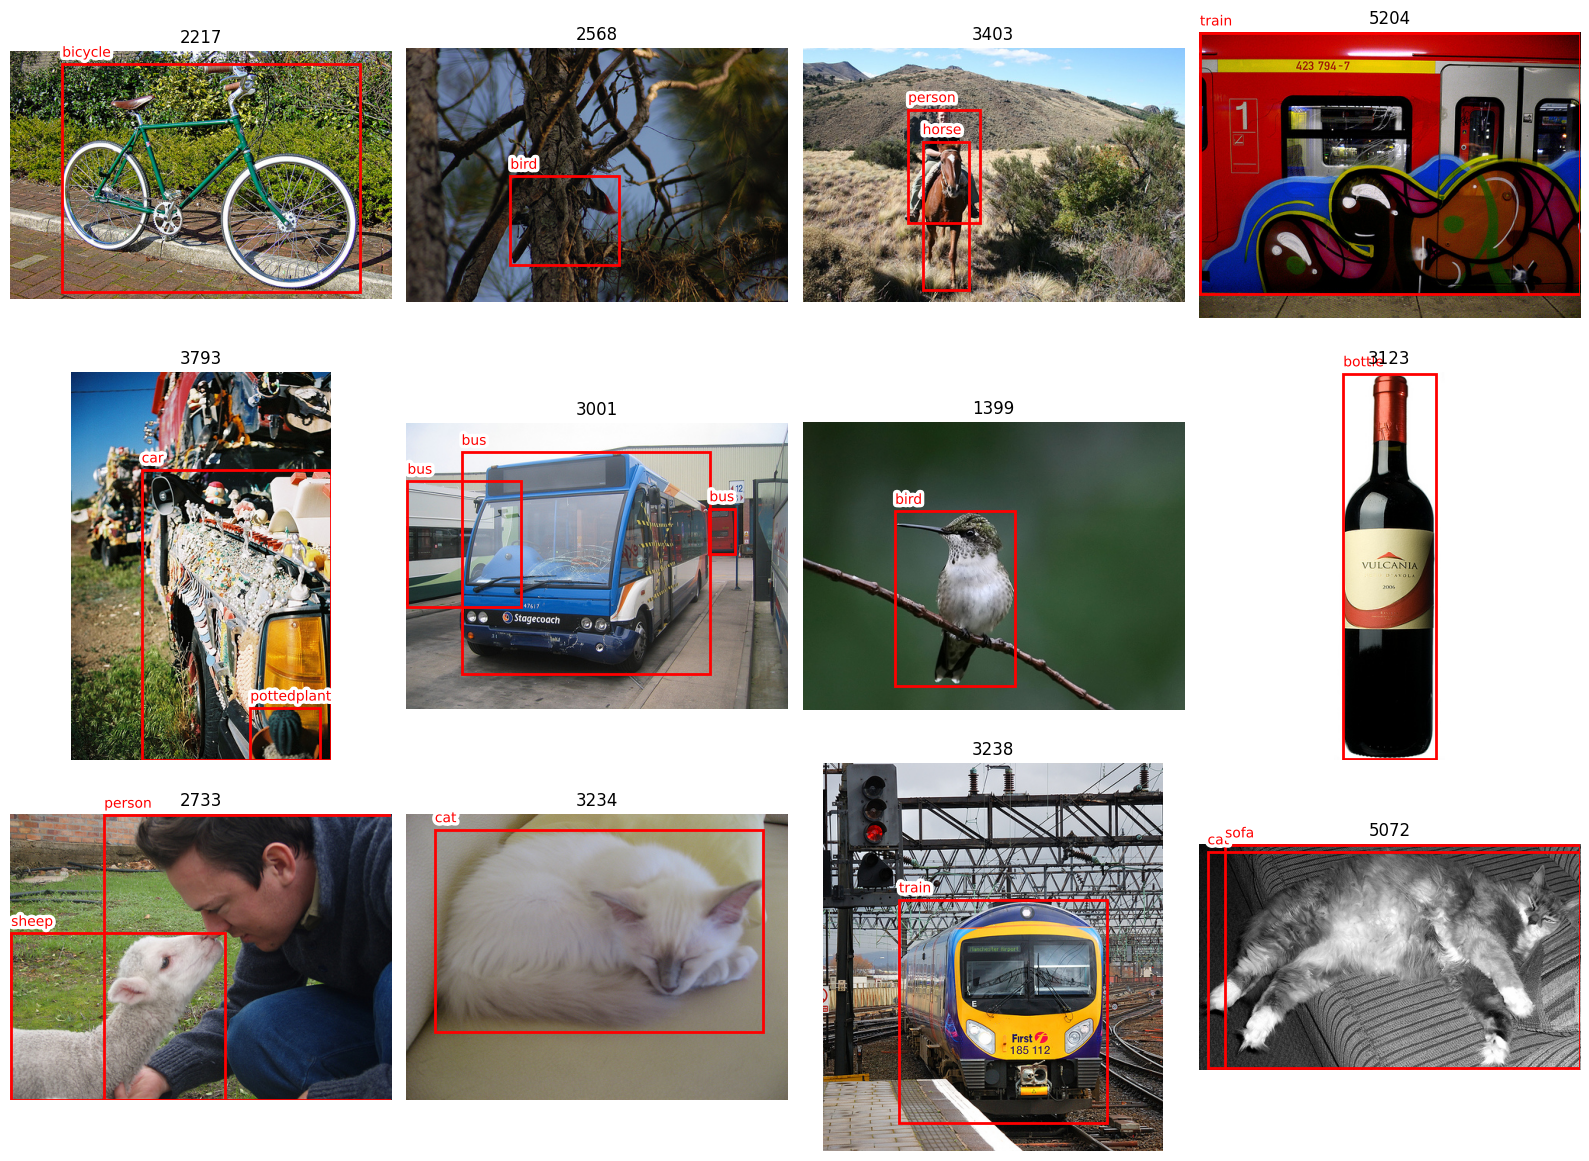

In [5]:
r, c = 3, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(train)-1)
        ax.set_title(ix)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        plt.axis("off")
plt.tight_layout()
plt.show()

Como puedes ver, en el dataset hay imágenes con una detección, otras con más de una. Algunas detecciones ocupan gran parte de la imagen, otras son pequeñas. En algunas imágenes incluso podemos tener múltiples detecciones de la misma clase... ¿Cómo podemos definir un modelo que sea capaz de darnos un número indeterminado de detecciones? En el caso del modelo `SSD`, y en general todos los detectores de una etapa, nosotros definimos un conjunto de cajas definido que la red utilizará durante el entrenamiento para generar detecciones.

## Propuesta de cajas

In [6]:
def norm(bb, shape):#normaliza la caja se lo pasa una caja es decir las coordenas y el tamano de la imagen
  # normalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, x_max, y_max]
  h, w = shape
  return np.array([bb[0]/w, bb[1]/h, bb[2]/w, bb[3]/h])

def unnorm(bb, shape):
  # unnormalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, x_max, y_max]
  h, w = shape
  return np.array([bb[0]*w, bb[1]*h, bb[2]*w, bb[3]*h])

def xyxy2xywh(bb):#cambiar la definicion de la cajas  el formato x min y min x max y max y nos convertira a lo convertirá x min y min ancho y alto esto con el proposito de dar formato ya que algunas funciones lo necesitan
  return torch.stack([bb[:,0], bb[:,1], bb[:,2]-bb[:,0], bb[:,3]-bb[:,1]], axis=1)

#def xywh2xyxy(bb):
#  return torch.stack([bb[:,0], bb[:,1], bb[:,0]+bb[:,2], bb[:,1]+bb[:,3]], axis=1)

def generate_anchors(scales, centers, sizes):#genera las cajas propuestas
    k, anchors, grid_size = [], [], []
    for s in scales:
        cnt = 0
        for (x, y) in centers:
            for (w, h) in sizes:#nos da una propuesta de caja
                for i in range(s):#iteran por la escala
                    for j in range(s):
                        # cwh
                        #anchors.append(np.array([x+i, y+j, w, h])/s)
                        # xyxy
                        anchors.append(np.array([x+i-w/2, y+j-h/2, x+i+w/2, y+j+h/2])/s)
                        grid_size.append(np.array([1./s,1./s]))
                cnt = cnt + 1
        k.append(cnt)
    return k, torch.tensor(anchors).float(), torch.tensor(grid_size).float()

A la función `generate_anchors` le damos una lista de diferentes escalas a las cuales queremos tener detecciones, otra con el centro de las cajas, la escala y el *aspect ratio*. La función nos devuelve una lista con todas las cajas que el modelo tendrá en cuenta durante el entrenamiento para detectar objetos en ellas.

In [7]:
def plot_anchors(img, anns, anchors, ax=None, overlap=False):
  # anns is a tuple with (bbs, labels)
  # bbs is an array of bounding boxes in format [x_min, y_min, x_max, y_max] 
  # labels is an array containing the label 
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns

  anchors = xyxy2xywh(anchors)
  _anchors = np.array([unnorm(a, img.shape[:2]) for a in anchors])
  for a in _anchors:
    x, y, w, h = a
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect)

  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    x, y, xm, ym = bb
    w, h = xm - x, ym - y
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
    text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
    text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
    ax.add_patch(rect)

<ipython-input-6-c0d3de9cc074>:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return k, torch.tensor(anchors).float(), torch.tensor(grid_size).float()


(138, [3, 3, 3])

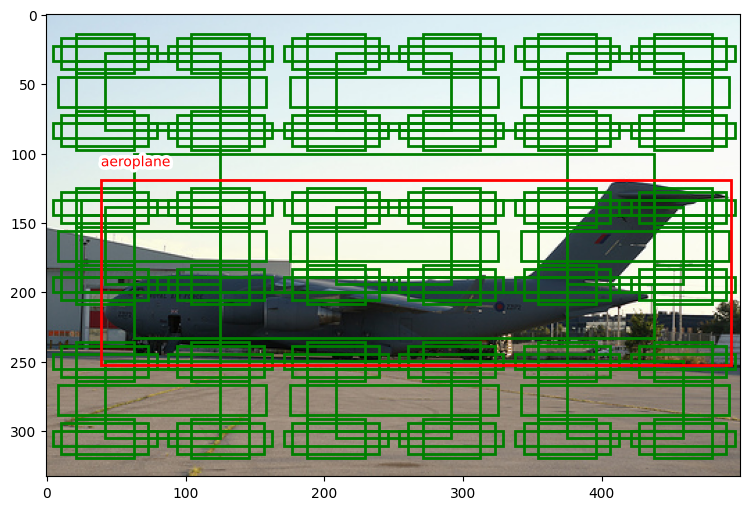

In [8]:
ix = 4445
img_np, anns = get_sample(ix)
labels, bbs = anns

scales = [6, 3, 1]               
centers = [(0.5, 0.5)] 
size_scales = [0.5]
aspect_ratios = [(1., 1.), (1.5, 0.8), (1.8, 0.4)]
sizes = [(s*a[0], s*a[1]) for s in size_scales for a in aspect_ratios]
k, anchors, grid_size = generate_anchors(scales, centers, sizes)

plot_anchors(img_np, anns, anchors)
len(anchors), k

La eficiencia y precisión del modelo dependerá del número de cajas que propongamos así como su número. Muchas cajas nos darán un modelo lento, pero potencialmente más preciso. Por otro lado, si en nuestra aplicación conocemos bien la escala y tamaño al que se encuentran los objetos que queremos detectar, poner sólo cajas en esas escalas dará como resultado un modelo preciso y eficiente (aquí estaremos introduciendo conocimiento experto, o *priors*, a nuestro modelo perdiendo flexibilidad).

Como puedes estar pensando, de querer ser capaces de detectar objetos de manera precisa simplemente con las cajas propuestas, deberíamos tener muchísimas de estas cajas (potencialmente cubriendo todo el espacio). Es por esto que nuestro modelo no sólo clasificará objetos dentro de las cajas propuestas sino que además también predecirá unos *offsets*, modificaciones sobre las cajas propuestas, para acabar de ajustar la detección (básicamente, un *offset* en el centro de la caja, su ancho y alto).

## El Modelo

Inspirándonos en la implementación del modelo `SSD` original, necesitamos una `backbone` que extraiga características de la imagen y luego varias `heads` que produzcan las clasificaciones y los *offests* sobre las cajas propuestas. Estas `heads` son alimentadas con las salidas de diferentes capas convolucionales de la `backbone`, permitiendo así la detección a múltiples escalas. Estas escalas deben coincidir con las definidas a la hora de generar nuestras propuestas de cajas (si no las dimensiones no encajarán).

`VGG-16 `es un modelo de red neuronal convolucional ampliamente utilizado en el campo de la visión por computadora. Fue desarrollado por el grupo Visual Geometry Group (VGG) de la Universidad de Oxford.

La arquitectura de VGG-16 se caracteriza por su profundidad, con un total de 16 capas, incluyendo capas convolucionales, capas de agrupamiento y capas completamente conectadas. La estructura de capas convolucionales consiste en bloques repetitivos de dos capas convolucionales seguidas de una capa de agrupamiento (también conocida como capa de pooling).

VGG-16 se destaca por su simplicidad y uniformidad en la arquitectura. Utiliza filtros de tamaño 3x3 en todas sus capas convolucionales y realiza agrupamiento máximo (max pooling) con ventanas de tamaño 2x2. Estas características permiten que la red aprenda representaciones jerárquicas de las imágenes con una buena capacidad de generalización.

VGG-16 ha demostrado un rendimiento sobresaliente en varios conjuntos de datos de visión por computadora, como el conjunto de datos ImageNet, donde logró un bajo error de clasificación y obtuvo buenos resultados en tareas de reconocimiento de objetos.

![](https://miro.medium.com/max/1100/1*up-gIJ9rPkHXUGRoqWuULQ.jpeg)

In [9]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        #torch.nn.BatchNorm2d(c_out),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def flatten_conv(x, k):
    return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2)#batchsize, dividimos la segunda dimension por el numero cajas, y el resto se acomoda ala tercera dimensiony 
    #finalmente realizar un transpose asi tener una tensor dividio en diferentes escalas

class out_conv(torch.nn.Module):# es como otro red neuronal
    def __init__(self, c_in, k, n_classes):
        super().__init__()
        self.k = k
        self.oconv1 = torch.nn.Conv2d(c_in, k*4, 3, padding=1)#devuelve una lista con las cajas de localizacion con flitros de 3
        self.oconv2 = torch.nn.Conv2d(c_in, k*n_classes, 3, padding=1)#devuelve una lista con las clases con lacantidad de cajas y el numero de probabilidad de las cajas
    def forward(self, x):
        return [
            flatten_conv(self.oconv1(x), self.k),
            flatten_conv(self.oconv2(x), self.k)
        ]

def conv(c_i, c_o, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(c_i, c_o, 3, stride=stride, padding=padding), 
        nn.ReLU(),
        #nn.BatchNorm2d(c_o)
    )


# class SSD(torch.nn.Module):
#   def __init__(self, n_channels=3, n_classes=20, k=[1, 1, 1]):
#     super().__init__()
#     # backbone
#     self.conv1 = block(n_channels, 8)
#     self.conv2 = block(8, 16)
#     self.conv3 = block(16, 32)
#     self.conv4 = block(32, 64)
#     self.conv5 = block(64, 64)
#     self.conv6 = block(64, 64)
#     # head
#     self.k = k #numero de cajas
#     self.out4 = out_conv(64, self.k[0], n_classes)
#     self.out5 = out_conv(64, self.k[1], n_classes)
#     self.out6 = out_conv(64, self.k[2], n_classes)

#   def forward(self, x):
#     # backbone
#     x = self.conv1(x)
#     x = self.conv2(x)
#     x = self.conv3(x)     # para inputs de 100x100
#     x4 = self.conv4(x)    # 6x6
#     x5 = self.conv5(x4)   # 3x3
#     x6 = self.conv6(x5)   # 1x1 objetivo tener o capturar los detallees de la imagen cuando toda la dimension asi se captura mejor los detalles de las caracteristicas

#     # head
#     o1l, o1c = self.out4(x4)
#     o2l, o2c = self.out5(x5)
#     o3l, o3c = self.out6(x6)
#     return torch.cat([o1l,o2l,o3l],dim=1), torch.cat([o1c,o2c,o3c],dim=1)    
    #return o2l, o2c

In [23]:
import torch.nn as nn
import torchvision.models as models

class SSD(nn.Module):
    def __init__(self, n_channels=3, n_classes=20, k=[1, 1, 1]):
        super().__init__()
        # Backbone
        mobilenet = models.mobilenet_v2(pretrained=True, progress=True)
        self.features = mobilenet.features
        self.conv0 = nn.Sequential(
            nn.Conv2d(160, 1280, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(1280, 320, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(320, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )
        
        # Head
        self.k = k  # Número de cajas
        self.out4 = out_conv(96, self.k[0], n_classes)
        self.out5 = out_conv(128, self.k[1], n_classes)
        self.out6 = out_conv(64, self.k[2], n_classes)

    def forward(self, x):
        # Backbone
        x = self.features[:7](x)
        x = self.features[7:14](x)
        x = self.features[14:17](x)
        x = self.conv0(x)
        x = self.conv1(x)
        x6 = self.conv6(x)
        
        # Head
        o1l, o1c = self.out4(x)
        o2l, oc = self.out5(x)
        o3l, o3c = self.out6(x6)
        
        return torch([o1l, o2l, o3l], dim=1), torch.cat([o1c, o2c, o3c], dim=1)


In [24]:
net = SSD(n_classes=len(classes), k=k)
output = net(torch.rand((64,3,100,100)))
output[0].shape, output[1].shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: ignored

## La función de pérdida

Durante el entrenamiento, el modelo nos dará 4 valores para cada una de las cajas propuestas (*offests*) así como las 21 probabilidades asignadas a cada clase. De alguna manera, la función de pérdida tiene que comparar estos valores con las cajas reales. En primer lugar tenemos que coger las salidas del modelo y calcular los *offsets*. Para ello, usaremos la función `tanh`, que limita los salidas a valores en el rango (-1, 1), permitiendo un *offset* de hasta el 50% del tamaños de la caja en ambas dimensiones.

In [ ]:
def actn_to_bb(actn, anchors, grid_size):#produuce variaciones en las cajas, recibe las receibe las 4 numeros de activaciones a,cajas propuestas,  su tamanoc de la caja
    actn_bbs = torch.tanh(actn)#converite los valores entre -1 y 1
    actn_p1 = anchors[:,:2] + actn_bbs[:,:2]*grid_size*0.5 #loque hacen es variar las cajas el centro de laja el alto y syu ancho hasta un 50%
    actn_p2 = anchors[:,2:] + actn_bbs[:,2:]*grid_size*0.5 #centro de las cajas estoa para el alto y ancho
    return torch.cat([actn_p1, actn_p2], dim=1)

El siguiente problema es que cada imagen tiene un número indeterminado de detecciones, por lo que primero tenemos que emparejar las cajas propuestas con aquellas anotaciones con las que mejor coincidan. Para ello usamos una métrica conocida como `IoU`(*intersection over unions*).

esta se calcula entre la realacion de entre 2 areas superpuestas y su union
cuando el valor de metrica es uno que es el maximo indica que la cajapredicha y caja predecir esta superpuestas y si es 0 pues que no lo estan

![](https://pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png)

Una vez calculado este valor para cada caja propuesta con respecto a todas las cajas en las etiquetas, nos quedamos con aquellas que superen un `threshold` determinado (por defecto 0.4). Es posible pues tener varias detecciones para un mismo objeto, algo que resolveremos más adelante. También puede ocurrir que no haya ninguna caja que cumpla estos requisitos, es este caso le asignaremos aquella con mayor `IoU`.

In [ ]:
def map_to_ground_truth(overlaps):#grandtrue deteteccions originales
    prior_overlap, prior_idx = overlaps.max(1)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap, gt_idx#nos devuelve los indicese lcas cajas que tenemos que corresponder con el gradtrue

Una vez hemos determinado las cajas que mejor aproximan las detecciones reales, usamos una combinación de `L1Loss` y `CrossEntropyLoss` para la localización y clasificación, respectivamente, igual que hicimos en este [post](https://sensioai.com/blog/047_cv_loc_clas).

In [ ]:
class SSDLoss(torch.nn.Module):
    def __init__(self, anchors, grid_size, threshold=0.4):
        super().__init__()
        self.loc_loss = torch.nn.L1Loss()#funciona perdidad para la localizacion
        self.class_loss = torch.nn.CrossEntropyLoss()#funcion perdida para la clasificacion
        self.anchors = anchors.to(device) #cajas propuestas
        self.grid_size = grid_size.to(device)#tamnoa de las cajas
        self.threshold = threshold

    def forward(self, preds, target):#funciona que se aplica cuando queremos calculas la funcion de perdida, recibe las cajas_predichas
        pred_bbs, pred_cs = preds 
        tar_bbs, c_t = target # B x O x 4, B x O
        # cada imagen del batch puede tener un número diferente de detecciones
        loc_loss, clas_loss = 0, 0
        for pred_bb, pred_c, tar_bb, tar_c in zip(pred_bbs, pred_cs, tar_bbs, c_t):
            labels = torch.zeros(len(self.anchors)).long().to(device) # por defecto todas las etiquetas son `background`
            if tar_bb.shape[0] is not 0: # es posible que haya imágenes sin detecciones
                # calculamos el IoU de las detecciones con las cajas
                overlaps = torchvision.ops.box_iou(tar_bb, self.anchors)#devuelve el iut
                # nos quedamos con aquellas que coincidan
                gt_overlap, gt_idx = map_to_ground_truth(overlaps)
                pos = gt_overlap > self.threshold
                # optimizamos para aquellas cajas que superen el filtro
                pos_idx = torch.nonzero(pos)[:,0]
                tar_idx = gt_idx[pos_idx]
                pred_bb = actn_to_bb(pred_bb, self.anchors, self.grid_size)
                _anchors = pred_bb[pos_idx]
                tar_bb = tar_bb[tar_idx]
                loc_loss += self.loc_loss(_anchors, tar_bb)
                labels[pos_idx] = tar_c[tar_idx]
                clas_loss += self.class_loss(pred_c, labels)
        return clas_loss + loc_loss

## Entrenamiento

Ahora ya tenemos todas las piezas en sus sitio para entrenar nuestro modelo. Vamos a hacer el fit de una sola imagen para simplificar las cosas de momento.

In [ ]:
def fit(model, X, target, epochs=1, lr=3e-4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = SSDLoss(anchors, grid_size)
    for epoch in range(1, epochs+1):
        model.train()
        train_loss_loc, train_loss_cls = [], []
        optimizer.zero_grad()
        outputs = model(X)#deeuvel las cjas y etiquetas
        loss = criterion(outputs, target)
        loss.backward()#calculamos los gradientes
        optimizer.step()#actualizamos los pesos cada paso de optimazion 
        train_loss_loc.append(loss.item())
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss_loc):.5f}")

Hemos diseñado nuestra red y nuestras cajas propuestas para trabajar con imágenes de 100 x 100 pixeles. Utilizamos albumentations para hacer el *resize* de la imagen y anotaciones.

In [ ]:
import albumentations as A

trans = A.Compose([
    A.Resize(100, 100)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

labels, bbs = anns
augmented = trans(**{'image': img_np, 'bboxes': bbs, 'labels': labels})
img, bbs, labels = augmented['image'], augmented['bboxes'], augmented['labels']

plot_anchors(img, (labels, bbs), anchors)
plt.show()

In [ ]:
img_tensor = torch.FloatTensor(img / 255.).permute(2,0,1).unsqueeze(0).to(device)
bb_norm = [norm(bb, img.shape[:2]) for bb in bbs]
bb_tensor = torch.FloatTensor(bb_norm).unsqueeze(0).to(device)
label_tensor = torch.tensor(labels).long().unsqueeze(0).to(device)

img_tensor.shape, bb_tensor.shape, label_tensor.shape

In [ ]:
model = SSD(n_classes = len(classes), k=k)
fit(model, img_tensor, (bb_tensor, label_tensor), epochs=100)

## Generando predicciones

Una vez tenemos nuestro modelo entrenado, podemos generar predicciones de la siguiente manera

In [ ]:
def predict(model, X):
    model.eval()
    with torch.no_grad():
        X = X.to(device)
        bbs, labels = model(X)
        bbs = actn_to_bb(bbs[0].cpu(), anchors, grid_size)
    return bbs, torch.max(torch.softmax(labels.cpu(), axis=2)[0], axis=1)

In [ ]:
bbs, (scores, labels) = predict(model, img_tensor)
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]

In [ ]:
plot_anns(img, (labels, bbs))
plt.show()

Tenemos tantas predicciones como cajas propuestas, y la mayoría por defecto tendrán asignada la clase `background` que no nos interesa, así que descartamos todas estas cajas.

In [ ]:
plot_anns(img, (labels, bbs), bg=0)
plt.show()

Aún así, es posible que tengamos varias detecciones para un mismo objeto. Para resolver este problema podemos aplicar el algoritmo `NMS`(*non maximum supression*) que calcula el `IoU` de las detecciones con la misma clase y, si este valor está por encima de un cierto *threshold*, devuelve solo la detección con mayor probabilidad.

In [ ]:
bbs, (scores, labels) = predict(model, img_tensor)
# quitar bg
bbs, labels, scores = bbs[labels > 0], labels[labels > 0], scores[labels > 0]
bbs, labels, scores

In [ ]:
nms_ixs = torchvision.ops.nms(bbs, scores, iou_threshold=0.8)
nms_ixs

In [ ]:
bbs, labels = bbs[nms_ixs], labels[nms_ixs]
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]
plot_anns(img, (labels, bbs))
plt.show()

Ahora puedes intentar entrenar este modelo para el resto de imágenes del dataset. Es posible aplicar *transfer learning*, sustituyendo nuestra `bakcbone` por una red preentrenada (por ejemplo `resenet`) y sacando las cabezas de detecciones de los diferentes mapas de características intermedios (puedes añadir capas extras para seguir reduciendo la dimensionalidad como en la implementación original).

## Resumen

En este post hemos aprendido a implementar un modelo de detección de objetos desde cero, inspirándonos en el modelo `SSD`. En primer lugar, hemos definido un conjunto de cajas que durante el entrenamiento nuestra red utilizará para detectar objetos. La salida de la red neuronal nos dará unos *offsets* sobre estas cajas a la vez que la distribución de probabilidad sobre todos los posibles objetos. Utilizamos la métric `IoU` para determinar qué cajas se parecen más a las anotaciones, y optimizar para sólo este conjunto. Por último, utilizamos el algorimto `NMS` para eliminar duplicados a la hora de generar predicciones.